In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# micrograd library
!pip install micrograd
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

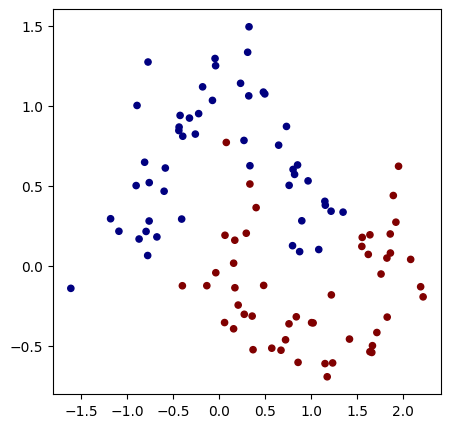

In [86]:
# make up a dataset

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.2)
y = y*2 - 1 # make y be -1 or 1 (rather than 0 and 1)
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [87]:
# initialize a model

model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("Number of parameters:", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Number of parameters: 337


In [88]:
# loss function

def loss(batch_size=None):

  # inline DataLoader :)
  if batch_size is None:
    Xb, yb = X, y
  else:
    ri = np.random.permutation(X.shape[0])[:batch_size]
    Xb, yb = X[ri], y[ri]
  inputs = [list(map(Value, xrow)) for xrow in Xb] # convert data to Value objects

  # forward the model to get scores
  scores = list(map(model, inputs))

  # svm "max-margin" loss
  losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
  data_loss = sum(losses) * (1.0 / len(losses))
  # L2 regularization
  alpha = 1e-4
  reg_loss = alpha * sum((p*p for p in model.parameters()))
  total_loss = data_loss + reg_loss

  # also get accuracy
  accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
  return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss.data, acc)

1.2583498131914923 0.37


(-1.695059512598319, 2.304940487401681)

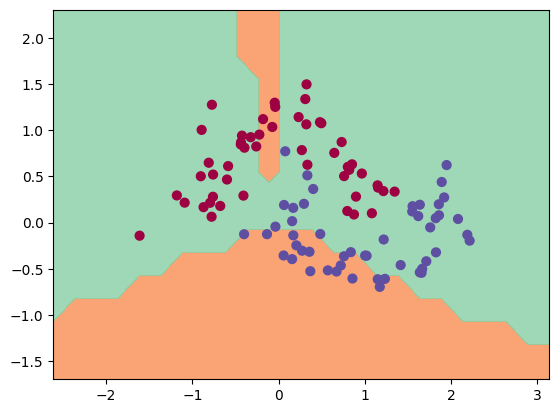

In [89]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [90]:
# optimization

for k in range(50):

  # forward
  total_loss, acc = loss()

  # backward
  model.zero_grad()
  total_loss.backward() # calculate gradient

  # update (sgd)
  learning_rate = 1.0 - 0.9*k/100
  for p in model.parameters():
    p.data -= learning_rate * p.grad # update weights

  if k % 1 == 0:
    print(f"step {k} | loss {total_loss.data}, accuracy {acc*100}%")

step 0 | loss 1.2583498131914923, accuracy 37.0%
step 1 | loss 0.5815738323439104, accuracy 72.0%
step 2 | loss 1.1234046834797795, accuracy 50.0%
step 3 | loss 1.2210497889660155, accuracy 68.0%
step 4 | loss 0.39155291588279534, accuracy 85.0%
step 5 | loss 0.5803015327868389, accuracy 86.0%
step 6 | loss 0.3277968302002394, accuracy 86.0%
step 7 | loss 0.4554366958807997, accuracy 86.0%
step 8 | loss 0.25692527617673744, accuracy 88.0%
step 9 | loss 0.25926183509814593, accuracy 91.0%
step 10 | loss 0.3381985193179781, accuracy 87.0%
step 11 | loss 0.2573060377562131, accuracy 91.0%
step 12 | loss 0.34189058979803666, accuracy 89.0%
step 13 | loss 0.22258009734517642, accuracy 90.0%
step 14 | loss 0.22056428780592352, accuracy 89.0%
step 15 | loss 0.22835295391034288, accuracy 92.0%
step 16 | loss 0.26260531974680934, accuracy 89.0%
step 17 | loss 0.19700989831556387, accuracy 90.0%
step 18 | loss 0.21382485007422483, accuracy 91.0%
step 19 | loss 0.23116408416732334, accuracy 92.0%

(-1.695059512598319, 2.304940487401681)

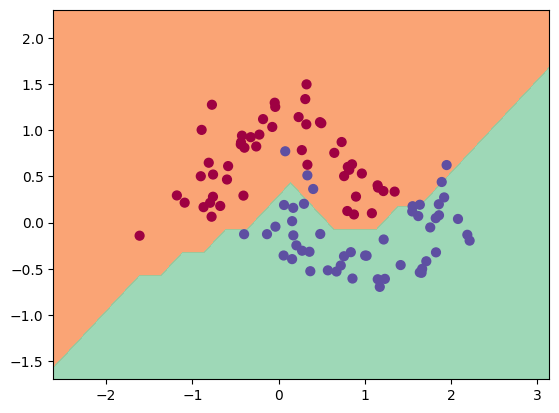

In [91]:
# visualize OPTIMIZED decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())